### Transactions from a bakery - Market Basket Analysis - Kaggle
**Data set** <br>
- Date: 2016-10-30  to 2017-04-09 <br>
- Time<br>
- Transaction<br>
- Item <br>

**Question to explore** <br>
- Data exploratory:
    - Busiest times of the day are from 9am-3pm, peaks around 10 am
    - Amount of transactions increases toward the end of week, peaks on Saturday
    - Among months that have full data (Nov-Mar), November has the highest number of transaction, but in general, there is not significant variation through months.
    - Examples of most popular items sold are coffee, bread, pastry, and cake
    
- Analyzing association of items: market basket analysis. Codes were modified from http://intelligentonlinetools.com/blog/2018/02/10/how-to-create-data-visualization-for-association-rules-in-data-mining/
- Time series prediction of daily number of  transactions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import random
from datetime import datetime
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## I-Exploratory Data Analysis

In [3]:
# Import data
df = pd.read_csv("BreadBasket_DMS.csv")
print(df.head())
print(df.info())
# Check unique item categories
print("No of unique item: {}".format(df['Item'].nunique()))
print("\n")
print("Top items and counts:","\n", df['Item'].value_counts().head(5))

         Date      Time  Transaction           Item
0  2016-10-30  09:58:11            1          Bread
1  2016-10-30  10:05:34            2   Scandinavian
2  2016-10-30  10:05:34            2   Scandinavian
3  2016-10-30  10:07:57            3  Hot chocolate
4  2016-10-30  10:07:57            3            Jam
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
Date           21293 non-null object
Time           21293 non-null object
Transaction    21293 non-null int64
Item           21293 non-null object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB
None
No of unique item: 95


Top items and counts: 
 Coffee    5471
Bread     3325
Tea       1435
Cake      1025
Pastry     856
Name: Item, dtype: int64


/Users/uyennguyen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


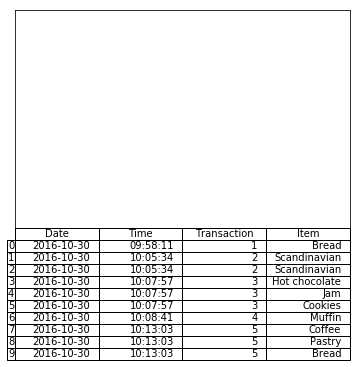

In [17]:
from pandas.tools.plotting import table

ax = plt.subplot(111)#, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
df1= df.head(10)
table(ax, df1)  # where df is your data frame

plt.savefig('mytable.png',bbox_inches='tight',dpi=200)

In [3]:
# Drop row of NONE items
df.drop(df[df['Item']=='NONE'].index,inplace=True)

In [4]:
# Create month and hour columns
df['Month'] = df['Date'].apply(lambda x:x.split("-")[1])
df['Hour'] = df['Time'].apply(lambda x:int(str(pd.to_datetime(x).round('H')).split(" ")[1].split(":")[0]))

# Get day of week column
#dayofweek = {0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}
#df['DayofWeek'] = df['Date'].apply(lambda x:dayofweek[pd.to_datetime(x).weekday()])

In [6]:
df = pd.read_csv("BreadBasket_DMS_modified.csv")
df.head()

,Date,Time,Transaction,Item,Month,Hour
0,10/30/16,9:58:11,1,Bread,10,10
1,10/30/16,10:05:34,2,Scandinavian,10,10
2,10/30/16,10:05:34,2,Scandinavian,10,10
3,10/30/16,10:07:57,3,Hot chocolate,10,10
4,10/30/16,10:07:57,3,Jam,10,10


Text(0.5,1,'Hourly number of transactions')

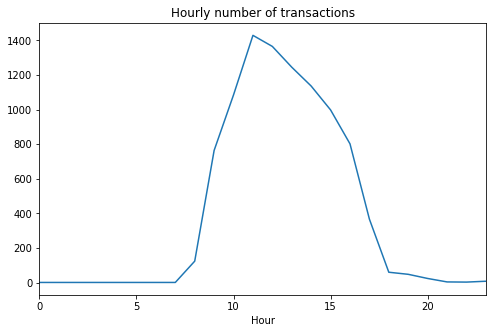

In [7]:
#Busiest hours
df.groupby('Hour')['Transaction'].nunique().plot(figsize=(8,5))
plt.title("Hourly number of transactions")

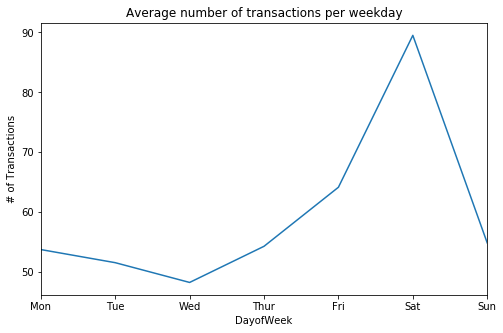

In [8]:
#Busiest day of week
#Get total transaction for each date
byday=df.groupby('Date')['Transaction'].nunique().reset_index()
#Create dayofweek column
byday['DayofWeek'] = byday['Date'].apply(lambda x:pd.to_datetime(x).weekday())

#Plot average transactions per day
byday.groupby('DayofWeek')['Transaction'].mean().plot(figsize=(8,5))
plt.title("Average number of transactions per weekday")
plt.ylabel("# of Transactions")
fig=plt.xticks(np.arange(7),['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])

Text(0.5,1,'Monthly number of transactions')

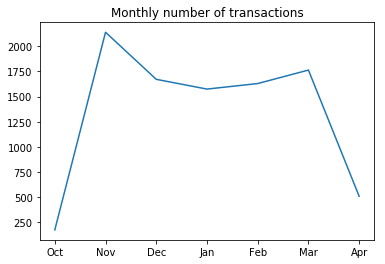

In [9]:
# Busiest months
bymonth=df.groupby("Month")['Transaction'].nunique().reset_index()
bymonth['Month'] = ['Jan','Feb','Mar','Apr','Oct','Nov','Dec']
bymonth['Order'] = [4,5,6,7,1,2,3]
bymonth.sort_values(by='Order',inplace=True)
plt.plot(bymonth['Month'],bymonth['Transaction'])
plt.title("Monthly number of transactions")

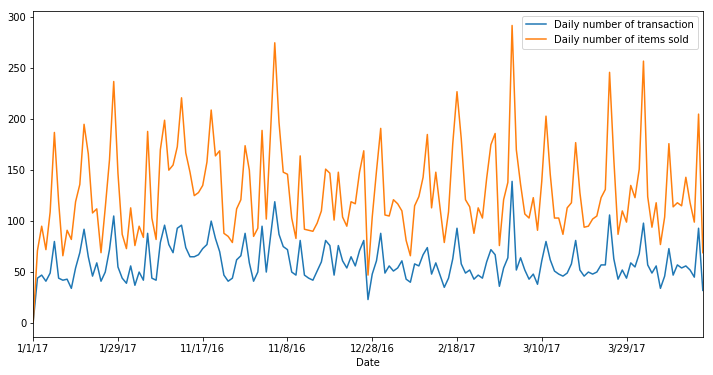

In [10]:
# Daily transaction
df.groupby("Date")['Transaction'].nunique().plot(figsize=(12,6),label="Daily number of transaction")
df.groupby("Date")['Transaction'].size().plot(figsize=(12,6),label="Daily number of items sold")
plt.legend(loc='best')

In [21]:
# Get counts of each item per hour for each months
byitem=df.groupby(["Month","Hour",'Item']).size().reset_index().sort_values(by="Hour")
byitem.rename(columns={0:'Total'},inplace=True)
byitem.head()

,Month,Hour,Item,Total
310,2,0,Valentine's card,1
0,1,1,Bread,1
1376,11,7,Coffee,1
1390,11,8,Tea,1
674,3,8,Truffles,1


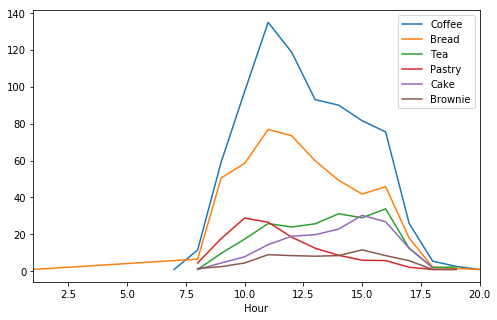

In [12]:
item_toplot = ['Coffee','Bread','Tea','Pastry','Cake','Brownie']
for item in item_toplot:
    byitem[byitem['Item']==item].groupby("Hour")['Total'].mean().plot(label=item,figsize=(8,5))

plt.legend(loc='best')

In [20]:
traces=[go.Scatter(
    x = byitem[byitem['Item']==item]['Hour'].unique(),
    y = byitem[byitem['Item']==item].groupby("Hour")['Total'].mean().round(1),
    mode = 'markers+lines',
    name = item
) for item in item_toplot]

layout = go.Layout(
    title = 'Average number of items sold at each hour'
)

fig = go.Figure(data=traces,layout=layout)
pyo.plot(fig)

'file:///Users/uyennguyen/Documents/Insight/Data Challenge/Kaggle/temp-plot.html'

In [14]:
df_agg = byitem.groupby(['Month','Hour','Item']).agg({'Total':sum})
g = df_agg['Total'].groupby(level=[0,1], group_keys=False)
topitem_hour=g.nlargest(5).reset_index()
topitem_hour.head(10)

,Month,Hour,Item,Total
0,1,1,Bread,1
1,1,8,Coffee,6
2,1,8,Pastry,2
3,1,8,Hot chocolate,1
4,1,8,Muffin,1
5,1,8,Scone,1
6,1,9,Coffee,63
7,1,9,Bread,49
8,1,9,Toast,16
9,1,9,Pastry,15


In [15]:
colors=['#848484','#3d567f','#70b578','#8923c4','#ffd77a','#e6b2ff',
              '#ff009d','#7f8400','#a3f2ff','#c1093a','#6b7cc6','#fc4cff','#0f8c01',
              '#ff8a00','#aeffa5','#cc8a3b','#ff7a9d','#ad4747','#f9ffb2','#ff0202',
              '#00fff2','#3a51ff','#73f4d8','#fffa00','#ff6600','#00b2ff','#cb00ff',
              '#59ed28','#c7fce9','#d2d6d1','#d1cd9c','#9b6a47','#ff7777','#499b5a',
              '#c49c68','#349dad','#b200ff','#7c0048','#289bc9']

In [18]:
df['Month'].iloc[0]

10

In [19]:
import plotly.offline as pyo
import plotly.graph_objs as go

month_dict = {1:'January',2:'February',3:'March',4:'April',10:'October',11:'November',12:'December'}
month = 11
month_item = topitem_hour[topitem_hour['Month']==month]['Item'].unique()

byitem_month = byitem[byitem['Month']==month][['Hour','Item','Total']]
byitem_month_pivot=pd.pivot_table(byitem_month,index='Hour',values='Total',columns='Item',fill_value=0,aggfunc='sum')[month_item]

cols=list(byitem_month_pivot.sum(axis=0).reset_index().sort_values(by=0)['Item'])
col_dicts = {}
for col in cols:
    col_dicts[col] = colors[cols.index(col)]

data = [go.Bar(x=byitem_month_pivot.index,y=byitem_month_pivot[col],name=col,marker={'color':col_dicts[col]}) for col in cols]
layout = go.Layout(title="Number of Items sold in " + month_dict[month],barmode='stack')
fig = go.Figure(data=data,layout=layout)

pyo.plot(fig)


'file:///Users/uyennguyen/Documents/Insight/Data Challenge/Kaggle/temp-plot.html'

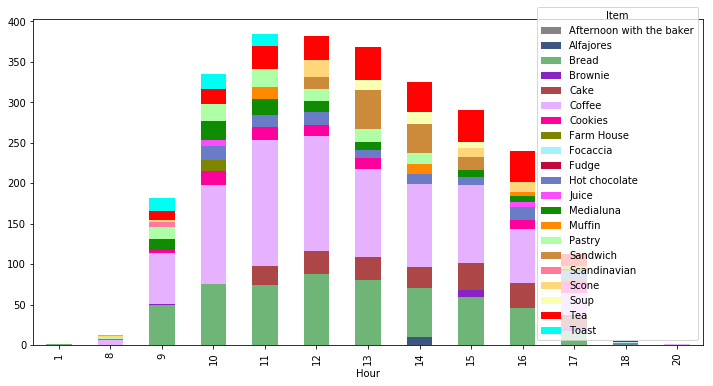

In [360]:
feb_pivot.plot(kind='bar',stacked=True,figsize=(12,6),color=colors)

## II-Market Basket Analysis

In [11]:
# Get the item basket lists for all transactions
items = []
for i in df['Transaction'].unique():
    items.append(list(set(df[df["Transaction"]==i]['Item'])))
    
items[0:5]

[['Bread'],
 ['Scandinavian'],
 ['Cookies', 'Jam', 'Hot chocolate'],
 ['Muffin'],
 ['Bread', 'Pastry', 'Coffee']]

In [38]:
with open('itemlist.csv','r') as f:
    filenames = [line.rstrip().split(',') for line in f]

In [5]:
tran_encoder = TransactionEncoder()
oht_ary = tran_encoder.fit(items).transform(items)
dataframe = pd.DataFrame(oht_ary, columns=tran_encoder.columns_)
print (dataframe.head())           

   Adjustment  Afternoon with the baker  Alfajores  Argentina Night  Art Tray  \
0       False                     False      False            False     False   
1       False                     False      False            False     False   
2       False                     False      False            False     False   
3       False                     False      False            False     False   
4       False                     False      False            False     False   

   Bacon  Baguette  Bakewell  Bare Popcorn  Basket        ...         \
0  False     False     False         False   False        ...          
1  False     False     False         False   False        ...          
2  False     False     False         False   False        ...          
3  False     False     False         False   False        ...          
4  False     False     False         False   False        ...          

   The BART  The Nomad  Tiffin  Toast  Truffles  Tshirt  Valentine's card  \
0  

In [9]:
frequent_itemsets = apriori(dataframe, use_colnames=True, min_support=0.02,max_len=None)
print (frequent_itemsets.head())
 
#association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.02)
rules.sort_values(by='lift',ascending=False,inplace=True)
print (rules.head())

    support     itemsets
0  0.036344  (Alfajores)
1  0.327205      (Bread)
2  0.040042    (Brownie)
3  0.103856       (Cake)
4  0.478394     (Coffee)
   antecedents  consequents  antecedent support  consequent support   support  \
11       (Tea)       (Cake)            0.142631            0.103856  0.023772   
10      (Cake)        (Tea)            0.103856            0.142631  0.023772   
27    (Coffee)      (Toast)            0.478394            0.033597  0.023666   
26     (Toast)     (Coffee)            0.033597            0.478394  0.023666   
19    (Coffee)  (Medialuna)            0.478394            0.061807  0.035182   

    confidence      lift  leverage  conviction  
11    0.166667  1.604781  0.008959    1.075372  
10    0.228891  1.604781  0.008959    1.111865  
27    0.049470  1.472431  0.007593    1.016699  
26    0.704403  1.472431  0.007593    1.764582  
19    0.073542  1.189878  0.005614    1.012667  


In [518]:
rules['antecedents'] = rules['antecedents'].apply(lambda x:list(x)[0])
rules['consequents']= rules['consequents'].apply(lambda x:list(x)[0])

In [522]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11,Tea,(Cake),0.143,0.104,0.024,0.167,1.605,0.009,1.075
10,Cake,(Tea),0.104,0.143,0.024,0.229,1.605,0.009,1.112
27,Toast,(Coffee),0.034,0.478,0.024,0.704,1.472,0.008,1.765
26,Coffee,(Toast),0.478,0.034,0.024,0.049,1.472,0.008,1.017
19,Medialuna,(Coffee),0.062,0.478,0.035,0.569,1.190,0.006,1.211


In [521]:
for col in ['antecedent support',
       'consequent support', 'support', 'confidence', 'lift', 'leverage',
       'conviction']:
    rules[col] = round(rules[col],3)

Text(0,0.5,'confidence')

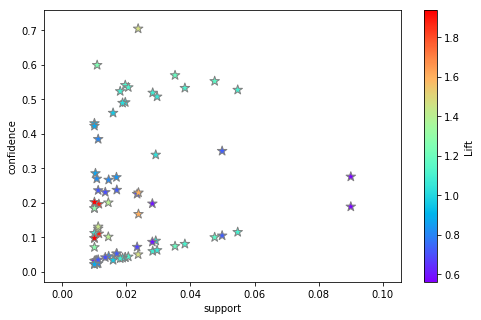

In [452]:
# Scatter plot of support vs. confidence
plt.figure(figsize=(8,5))
plt.scatter(rules['support'],rules['confidence'],marker='*',edgecolors='grey',s=100,c=rules['lift'],cmap='rainbow')
plt.colorbar(label='Lift')
plt.xlabel('support')
plt.ylabel('confidence') 

In [493]:
rules_to_show=len(rules)

colormap = plt.get_cmap('Reds')
colorlist=colormap(rules['lift']**2/(1 + rules['lift'] ** 2))
colorlist=["rgb"+str(tuple(i[0:3])) for i in colorlist]

def PointsInCircum(r,n):
    import math
    return [math.cos(2*math.pi/n*x)*r for x in np.arange(0,n+1)], [math.sin(2*math.pi/n*x)*r for x in np.arange(0,n+1)]
cir_x,cir_y = PointsInCircum(40,rules_to_show*2)[0],PointsInCircum(40,rules_to_show*2)[1]

import networkx as nx  
G1 = nx.DiGraph()

rule_lists=[]
for i in range(rules_to_show):
    rule_lists.append('R'+str(i))

for i in range (rules_to_show):      
    G1.add_nodes_from(["R"+str(i)])
    for a in rules.iloc[i]['antecedents']:
        G1.add_nodes_from([a])        
        G1.add_edge(a, "R"+str(i))       
    for c in rules.iloc[i]['consequents']:         
        G1.add_nodes_from([c])
        G1.add_edge("R"+str(i), c)

sizes = []
color_map = []
j=0
pos = {}
texts = []
index1 = -(int(rules_to_show/5)+1)
index2 = int(rules_to_show/5+1)
for node in G1:
    if node in rule_lists:
        color_map.append(colorlist[j])
        sizes.append(rules['confidence'].iloc[j]*50+5)
        pos[node]= [cir_x[index1],cir_y[index1]]
        texts.append(node+'<br>'+'support = '+str(round(rules['support'].iloc[j],3))
                    + '<br>'+'confidence = '+str(round(rules['confidence'].iloc[j],2))
                    + '<br>'+'lift = '+str(round(rules['lift'].iloc[j],2)))
        index1 -= 1 
        j += 1
    else:
        color_map.append('#f766ff')  
        sizes.append(20)
        pos[node]= [cir_x[index2],cir_y[index2]]
        texts.append(node)
        index2 +=1
        

In [497]:
node_trace = go.Scatter(
    x=[],
    y=[],
    text=texts,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=color_map,
        size=sizes,
        line=dict(width=2,color="black")))


for node in G1:
    node_trace['x'].append(pos[node][0])
    node_trace['y'].append(pos[node][1])

x0s = []
x1s = []
y0s = []
y1s = []
for edge in G1.edges():
    x0s.append(pos[edge[0]][0])
    x1s.append(pos[edge[1]][0])
    y0s.append(pos[edge[0]][1])
    y1s.append(pos[edge[1]][1])
    
fig = go.Figure(data=[node_trace],
             layout=go.Layout(
                title='<br>Network graph of market basket analysis - Association rule learning<br>',
                titlefont=dict(size=20),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=True,             
                    arrowhead=3,
                    arrowsize=1,
                    arrowwidth=1.2,
                    arrowcolor='#808080',
                    ax=x0s[i], ay=y0s[i], axref='x', ayref='y',
                    x=x1s[i], y=y1s[i], xref='x', yref='y',
                    yshift=-3) for i in range(len(x0s))],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

pyo.plot(fig)

'file:///Users/uyennguyen/Documents/Insight/Data Challenge/Kaggle/temp-plot.html'

In [160]:
def draw_graph(rules, rules_to_show):
    import networkx as nx  
    plt.figure(figsize=(8,8))
    G1 = nx.DiGraph()
    
    color_map=[]
    N = 400
    colors = np.random.rand(N) 
    strs=[]
    for i in range(rules_to_show):
        strs.append('R'+str(i))
   
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])    
        
        for a in rules.iloc[i]['antecedents']:                
            G1.add_nodes_from([a])        
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 1)
       
        for c in rules.iloc[i]['consequents']:         
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight= 1)
 
    for node in G1:
        if node in strs:
            color_map.append('yellow')
        else:
            color_map.append('green')  
        
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]

    #pos = nx.spring_layout(G1, k=50, scale=1,center=[0,0])
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
    for p in pos:  # raise text positions
        pos[p][1] +=0.05
    nx.draw_networkx_labels(G1, pos)
    return G1

In [193]:
G1.edges

OutEdgeView([('R0', 'Bread'), ('Cake', 'R0'), ('Cake', 'R9'), ('Cake', 'R10'), ('Bread', 'R1'), ('Bread', 'R3'), ('Bread', 'R5'), ('Bread', 'R7'), ('R1', 'Cake'), ('R2', 'Bread'), ('Coffee', 'R2'), ('Coffee', 'R8'), ('Coffee', 'R12'), ('Coffee', 'R14'), ('Coffee', 'R17'), ('Coffee', 'R18'), ('Coffee', 'R21'), ('Coffee', 'R22'), ('Coffee', 'R24'), ('Coffee', 'R26'), ('R3', 'Coffee'), ('R4', 'Bread'), ('Pastry', 'R4'), ('Pastry', 'R20'), ('R5', 'Pastry'), ('R6', 'Bread'), ('Tea', 'R6'), ('Tea', 'R11'), ('Tea', 'R25'), ('R7', 'Tea'), ('R8', 'Cake'), ('R9', 'Coffee'), ('R10', 'Tea'), ('R11', 'Cake'), ('R12', 'Cookies'), ('Cookies', 'R13'), ('R13', 'Coffee'), ('R14', 'Hot chocolate'), ('Hot chocolate', 'R15'), ('R15', 'Coffee'), ('R16', 'Coffee'), ('Juice', 'R16'), ('R17', 'Juice'), ('R18', 'Medialuna'), ('Medialuna', 'R19'), ('R19', 'Coffee'), ('R20', 'Coffee'), ('R21', 'Pastry'), ('R22', 'Sandwich'), ('Sandwich', 'R23'), ('R23', 'Coffee'), ('R24', 'Tea'), ('R25', 'Coffee'), ('R26', 'Toast

In [153]:
pos = {}
index1 = 0
index2 = -3
for node in G1:
    if node == "Coffee":
        pos['Coffee']=[0,0]
    else:
        if node not in strs:
            pos[node]= [cir_x[index1],cir_y[index1]]
            index1 += 1 
        else:
            pos[node]= [cir_x[index2],cir_y[index2]]
            index2 -=1

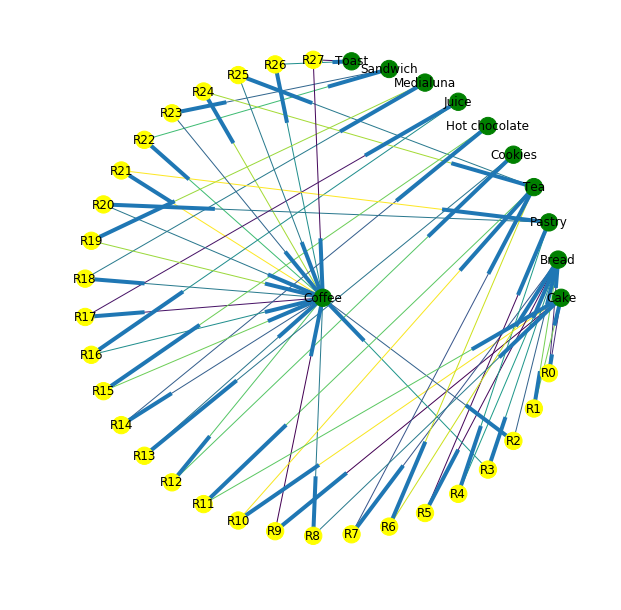

In [161]:
G1=draw_graph(rules,len(rules))
#nx.get_node_attributes(G1,'pos')

In [508]:
color_map=[]

for node in G1:
    if node in strs:
        color_map.append('yellow')
    else:
        color_map.append('green')  

In [510]:
color_map[0:10]

['yellow',
 'green',
 'green',
 'yellow',
 'yellow',
 'green',
 'yellow',
 'yellow',
 'green',
 'yellow']

In [511]:
G1.node

NodeView(('R0', 'Cake', 'Bread', 'R1', 'R2', 'Coffee', 'R3', 'R4', 'Pastry', 'R5', 'R6', 'Tea', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'Cookies', 'R13', 'R14', 'Hot chocolate', 'R15', 'R16', 'Juice', 'R17', 'R18', 'Medialuna', 'R19', 'R20', 'R21', 'R22', 'Sandwich', 'R23', 'R24', 'R25', 'R26', 'Toast', 'R27'))

## III-Time Series prediction of daily number of transactions

In [250]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [80]:
transac = df.groupby("Date")['Transaction'].nunique().reset_index()
transac.set_index("Date",inplace=True)
transac.index = pd.to_datetime(transac.index)
transac['Transaction']=transac['Transaction'].astype(float)

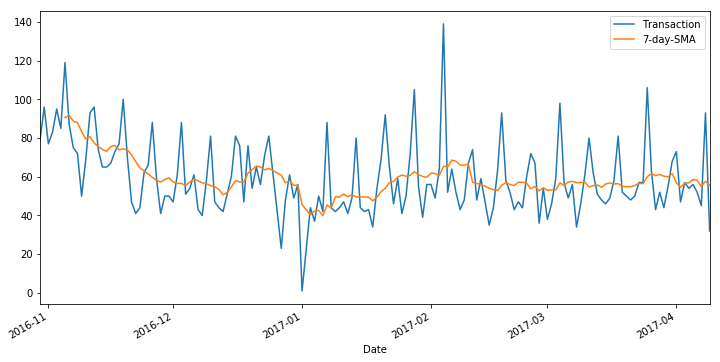

In [82]:
transac['7-day-SMA'] = transac['Transaction'].rolling(window=7).mean()
transac.plot(figsize=(12,6))

In [241]:
ts = transac['Transaction']

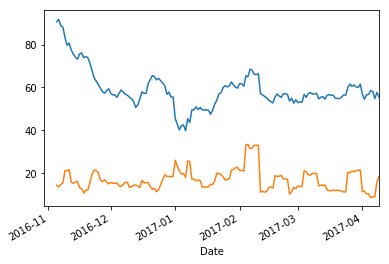

In [242]:
ts.rolling(7).mean().plot(label='7 Day Rolling Mean')
ts.rolling(7).std().plot(label= '7 Day Rolling Std')

<Figure size 432x288 with 0 Axes>

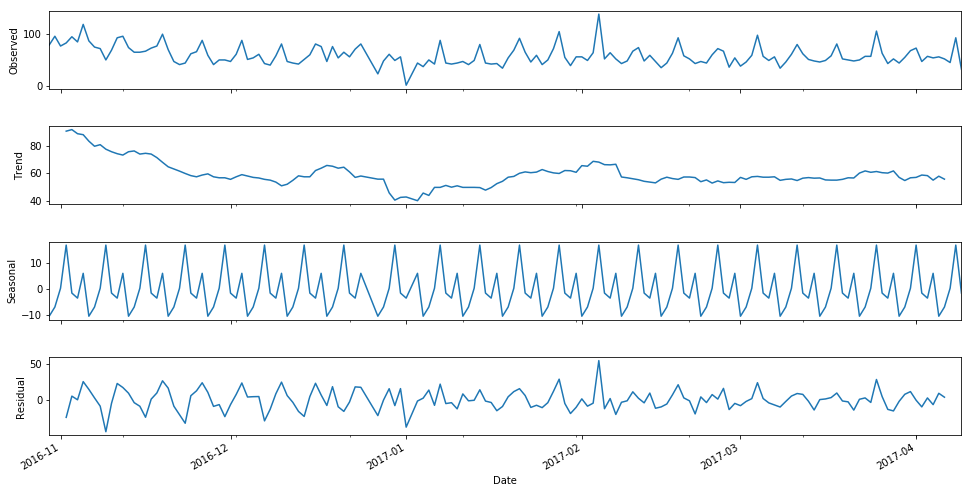

In [247]:
decomposition = seasonal_decompose(transac['Transaction'], freq=7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [248]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [249]:
adf_check(ts)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.2695454915406135
p-value : 0.016295900505702263
#Lags Used : 13
Number of Observations Used : 145
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


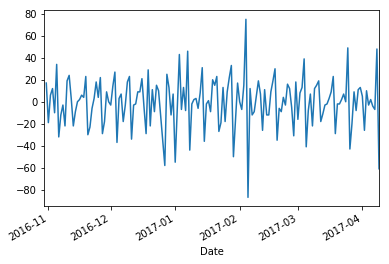

In [251]:
transac['First Difference'] = transac['Transaction'] - transac['Transaction'].shift(1)
transac['First Difference'].plot()

In [257]:
transac['Seasonal Difference'] = transac['First Difference'] - transac['First Difference'].shift(7)
transac['Seasonal Difference'].plot()

In [258]:
adf_check(transac['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.536184415571475
p-value : 1.7426405554259933e-06
#Lags Used : 14
Number of Observations Used : 136
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


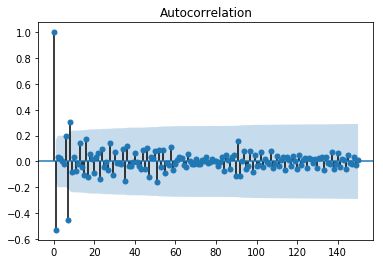

In [259]:
acf=plot_acf(transac['Seasonal Difference'].dropna())

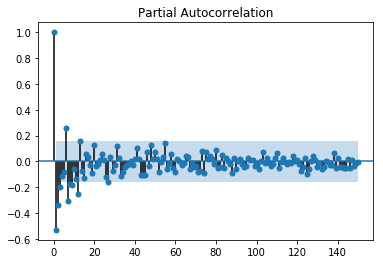

In [260]:
pacf = plot_pacf(transac['Seasonal Difference'].dropna())

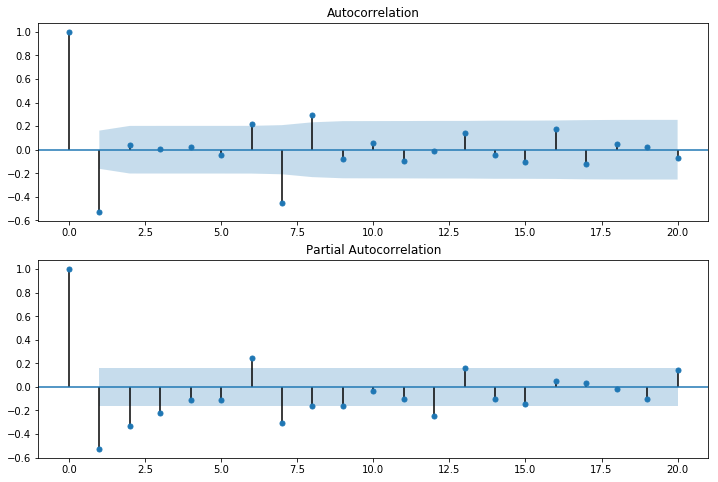

In [263]:
from pandas.plotting import autocorrelation_plot
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(transac['Seasonal Difference'].iloc[13:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(transac['Seasonal Difference'].iloc[13:], lags=20, ax=ax2)

In [269]:
# We have seasonal data!
model = sm.tsa.statespace.SARIMAX(transac['Transaction'],order=(1,0,0), seasonal_order=(1,1,1,7))
results = model.fit()
print(results.summary())

/Users/uyennguyen/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1042: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


                                 Statespace Model Results                                
Dep. Variable:                       Transaction   No. Observations:                  159
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 7)   Log Likelihood                -617.837
Date:                           Sun, 14 Oct 2018   AIC                           1243.674
Time:                                   17:51:38   BIC                           1255.949
Sample:                               10-30-2016   HQIC                          1248.659
                                    - 04-09-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2266      0.083      2.737      0.006       0.064       0.389
ar.S.L7       -0.1040      0.205     -0.508

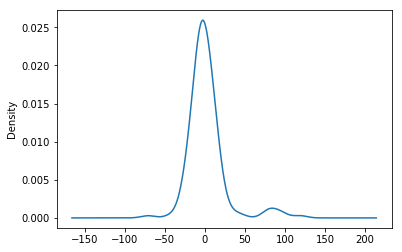

In [265]:
results.resid.plot(kind='kde')

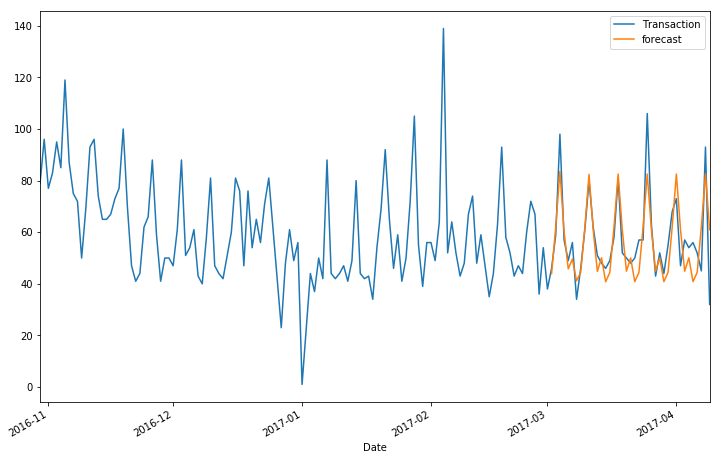

In [266]:
transac['forecast'] = results.predict(start = 120, end= 158, dynamic= True)  
transac[['Transaction','forecast']].plot(figsize=(12,8))

In [267]:
from pandas.tseries.offsets import DateOffset
future_dates = [transac.index[-1] + DateOffset(n=x) for x in range(0,100) ]
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=transac.columns)
future_df = pd.concat([transac,future_dates_df])


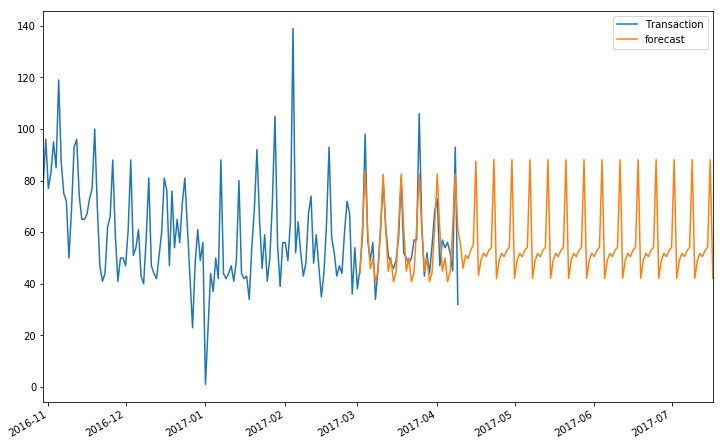

In [268]:
future_df['forecast'] = list(future_df['forecast'][0:159])+list(results.predict(start=158,end=256))
future_df[['Transaction', 'forecast']].plot(figsize=(12, 8)) 